# Sentiment analysis of app reviews - Preprocessing of the scraped app
Following this tutorial part 2 preprocess data -works only on Windows and Linux machine not MacOs

In [9]:
pip install -qq transformers

In [10]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch

import numpy as np
from tqdm import tqdm
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)


In [11]:
torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

device(type='cuda', index=0)

In [12]:
#!gdown --id 1S6qMioqPJjyBLpLVz4gmRTnJHnjitnuV
#!gdown --id 1zdmewp7ayS4js4VtrJEHzAheSW-5NBZv

In [13]:
reviews_df = pd.read_csv('reviews.csv')
#apps_df = pd.read_csv('apps.csv')

In [14]:
reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16232 entries, 0 to 16231
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   appID                 16232 non-null  object
 1   at                    16232 non-null  object
 2   content               16232 non-null  object
 3   repliedAt             8308 non-null   object
 4   replyContent          8308 non-null   object
 5   reviewCreatedVersion  13970 non-null  object
 6   reviewId              16232 non-null  object
 7   score                 16232 non-null  int64 
 8   sortOrder             16232 non-null  object
 9   thumbsUpCount         16232 non-null  int64 
 10  userImage             16232 non-null  object
 11  userName              16232 non-null  object
dtypes: int64(2), object(10)
memory usage: 1.5+ MB


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 0, 'reviews score')

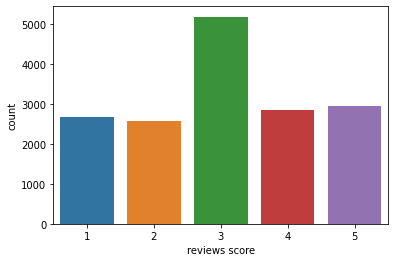

In [15]:
sns.countplot(reviews_df.score)
plt.xlabel('reviews score')

In [16]:
def to_sentiment(rating):
  rating = int(rating)
  if rating <=2:
    return 0 #negative sentiment rating 2 or lower
  elif rating ==3:
    return 1 # neutral sentiment rating 3
  else:
    return 2 # positive sentiment rating 4 or higher

In [17]:
reviews_df['sentiment']=reviews_df.score.apply(to_sentiment)

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


[Text(0, 0, 'negative'), Text(0, 0, 'neutral'), Text(0, 0, 'positive')]

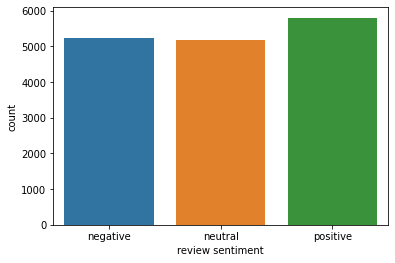

In [18]:
class_names = ['negative', 'neutral', 'positive']
ax = sns.countplot(reviews_df.sentiment)
plt.xlabel('review sentiment')
ax.set_xticklabels(class_names)

## Data Preprocessing

In [19]:
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-cased')

In [20]:
sample_text = "Do not buy those stocks, they are toxic bababaren. I don't know what you mean"
# tokenize text
tokens = tokenizer.tokenize(sample_text)
print('Tokenized sentence:',tokens)
# convert tokens to ids
token_ids = tokenizer.convert_tokens_to_ids(tokens)
print('Token ids:',token_ids)

Tokenized sentence: ['Do', 'not', 'buy', 'those', 'stocks', ',', 'they', 'are', 'toxic', 'b', '##aba', '##bar', '##en', '.', 'I', 'don', "'", 't', 'know', 'what', 'you', 'mean']
Token ids: [2091, 1136, 4417, 1343, 17901, 117, 1152, 1132, 12844, 171, 19252, 6824, 1424, 119, 146, 1274, 112, 189, 1221, 1184, 1128, 1928]


## Special Tokens

In [21]:
# Seperation okens and id
tokenizer.sep_token, tokenizer.sep_token_id

('[SEP]', 102)

In [22]:
# Classification tokens and id
tokenizer.cls_token, tokenizer.cls_token_id

('[CLS]', 101)

In [23]:
# Padding token and id
tokenizer.pad_token, tokenizer.pad_token_id

('[PAD]', 0)

In [24]:
# Token for unknown tokens
# tokenizer.unk_token, tokenizer.unk_token_id

In [25]:
# Encode text with tokenizer
encoding = tokenizer.encode_plus(
    sample_text,
    max_length=32, # set max length
    add_special_tokens=True, # add tokens for seperation, classification, padding, unknown
    padding='max_length', # all sentences have to have same length, padd to set max length
    return_attention_mask=True, # return attention masks of transformers
    return_token_type_ids=False, # 
    return_tensors='pt', # return encoded tokens as pytorch tokens
    truncation=True
)

encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

In [26]:
encoding['input_ids']

tensor([[  101,  2091,  1136,  4417,  1343, 17901,   117,  1152,  1132, 12844,
           171, 19252,  6824,  1424,   119,   146,  1274,   112,   189,  1221,
          1184,  1128,  1928,   102,     0,     0,     0,     0,     0,     0,
             0,     0]])

In [27]:
encoding['attention_mask']

tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         0, 0, 0, 0, 0, 0, 0, 0]])

## Chosing sequence length

In [28]:
token_lens = []
for txt in tqdm(reviews_df.content):
  tokens = tokenizer.encode(txt, max_length=512, truncation=True)
  token_lens.append(len(tokens))


100%|██████████| 16232/16232 [00:09<00:00, 1718.90it/s]


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0, 'Token length')

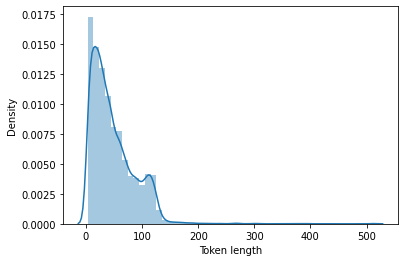

In [29]:
sns.distplot(token_lens)
plt.xlabel('Token length')

## Create Dataset

In [30]:
class GPReviewDataset(Dataset):
  def __init__(self, review, target, tokenizer, max_len):
    self.review = review
    self.target = target
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
    return len(self.review)

  def __getitem__(self, item):
    review = str(self.review[item])
    target = self.target[item]

    encoding = tokenizer.encode_plus(
        review,
        max_length=self.max_len, # set max length
        add_special_tokens=True, # add tokens for seperation, classification, padding, unknown
        padding='max_length', # all sentences have to have same length, padd to set max length
        return_attention_mask=True, # return attention masks of transformers
        return_token_type_ids=False, # 
        return_tensors='pt', # return encoded tokens as pytorch tokens,
        truncation=True
    )

    return {
        'review_text':review,
        'input_ids': encoding['input_ids'].flatten(),
        'attention_mask': encoding['attention_mask'].flatten(),
        'targets': torch.tensor(target, dtype= torch.long)
    }


In [31]:
max_len = 160
batch_size = 16
epochs = 10

In [32]:
# split data for training and testing
df_train, df_test = train_test_split(reviews_df, test_size=0.2, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size = 0.5, random_state=RANDOM_SEED)

In [33]:
df_train.shape, df_val.shape, df_test.shape

((12985, 13), (1623, 13), (1624, 13))

In [34]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = GPReviewDataset(
      review = df.content.to_numpy(),
      target = df.sentiment.to_numpy(),
      tokenizer = tokenizer,
      max_len=max_len
  )
  return DataLoader(
      ds,
      batch_size = batch_size,
      num_workers=4
  )

In [35]:
train_data_loader = create_data_loader(df_train, tokenizer, max_len, batch_size)
val_data_loader = create_data_loader(df_val, tokenizer, max_len, batch_size)
test_data_loader = create_data_loader(df_test, tokenizer, max_len, batch_size)

In [36]:
data = next(iter(train_data_loader))
data.keys()

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])

In [37]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([16, 160])
torch.Size([16, 160])
torch.Size([16])


# Sentiment analysis

In [38]:
bert_model = BertModel.from_pretrained('bert-base-cased')

In [39]:
last_hidden_state, pooled_output = bert_model(input_ids=encoding['input_ids'],
           attention_mask=encoding['attention_mask'])

In [40]:
last_hidden_state.shape

torch.Size([1, 32, 768])

In [41]:
pooled_output.shape

torch.Size([1, 768])

In [42]:
# get size of last hidden layer
bert_model.config.hidden_size

768


## Building a Sentiment Classifier

In [43]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'
class SentimentClassifier(nn.Module):

  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  
  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    output = self.drop(pooled_output)
    return self.out(output)

In [44]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = SentimentClassifier(len(class_names))
model = model.to(device)

In [45]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

In [46]:
attention_mask.shape, input_ids.shape

(torch.Size([16, 160]), torch.Size([16, 160]))

In [47]:
 torch.cuda.empty_cache()

In [48]:
nn.functional.softmax(model(input_ids, attention_mask), dim=1)

tensor([[0.4138, 0.1874, 0.3988],
        [0.5037, 0.1421, 0.3542],
        [0.2686, 0.1253, 0.6061],
        [0.5980, 0.0955, 0.3066],
        [0.6038, 0.1697, 0.2265],
        [0.3440, 0.1479, 0.5081],
        [0.4109, 0.1123, 0.4769],
        [0.3180, 0.2613, 0.4207],
        [0.3256, 0.1545, 0.5199],
        [0.2494, 0.2318, 0.5188],
        [0.4064, 0.1732, 0.4204],
        [0.3969, 0.2122, 0.3910],
        [0.5378, 0.0853, 0.3769],
        [0.4957, 0.1659, 0.3384],
        [0.3481, 0.1980, 0.4538],
        [0.3652, 0.2278, 0.4070]], device='cuda:0', grad_fn=<SoftmaxBackward>)

## Training the model

In [49]:
EPOCHS = 10

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [50]:
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  scheduler, 
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0
  
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

In [51]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

In [52]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler, 
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn, 
    device, 
    len(df_val)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/10
----------
Train loss 0.7389828247463175 accuracy 0.6712360415864459
Val   loss 0.654079410667513 accuracy 0.7196549599507086

Epoch 2/10
----------
Train loss 0.4538390641857691 accuracy 0.823950712360416
Val   loss 0.6370912531719488 accuracy 0.773875539125077

Epoch 3/10
----------
Train loss 0.2701192695201315 accuracy 0.9116673084328071
Val   loss 0.7443290316298896 accuracy 0.8065311152187308

Epoch 4/10
----------
Train loss 0.18100770341511702 accuracy 0.9479399306892569
Val   loss 0.9020123746538279 accuracy 0.8102279728897105

Epoch 5/10
----------
Train loss 0.13155255259130508 accuracy 0.9625721986907971
Val   loss 1.0408754447913344 accuracy 0.8194701170671597

Epoch 6/10
----------
Train loss 0.09750178817867788 accuracy 0.9735078937235272
Val   loss 1.1197643292640957 accuracy 0.8237831176833026

Epoch 7/10
----------
Train loss 0.07739120682032223 accuracy 0.9783596457450905
Val   loss 1.1776516780841584 accuracy 0.8207024029574862

Epoch 8/10
----------
Trai

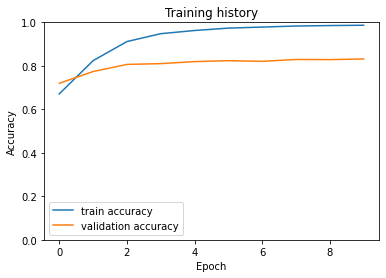

In [53]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [ ]:
# model = SentimentClassifier(len(class_names))
# model.load_state_dict(torch.load('best_model_state.bin'))
# model = model.to(device)

In [57]:


def get_predictions(model, data_loader):
  model = model.eval()
  
  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["review_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      probs = torch.nn.functional.softmax(outputs, dim=1)

      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values

In [58]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

In [59]:
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

    negative       0.84      0.86      0.85       533
     neutral       0.75      0.79      0.77       485
    positive       0.91      0.85      0.88       606

    accuracy                           0.84      1624
   macro avg       0.83      0.83      0.83      1624
weighted avg       0.84      0.84      0.84      1624



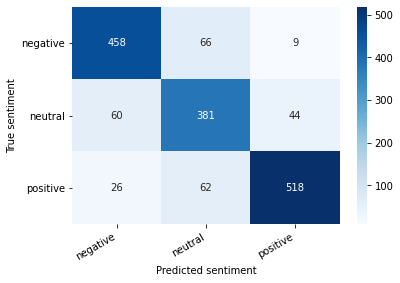

In [60]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

Predicting on Raw Text

Let's use our model to predict the sentiment of some raw text:

In [61]:
review_text = "I love completing my todos! Best app ever!!!"

In [63]:
encoded_review = tokenizer.encode_plus(
  review_text,
  max_length=max_len,
  add_special_tokens=True,
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',
)

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1773: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [64]:
input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)

output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)

print(f'Review text: {review_text}')
print(f'Sentiment  : {class_names[prediction]}')

Review text: I love completing my todos! Best app ever!!!
Sentiment  : positive
